<a href="https://colab.research.google.com/github/BioGeMT/DLforGenomics/blob/main/notebooks/Interpretation_of_1D_CNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Imports

In [1]:
!pip install logomaker
!pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 60.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.3 MB/s eta 0:00:00


In [2]:
from tensorflow import keras as K
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, precision_recall_curve, classification_report
import logomaker
import shap
import matplotlib.cm as cm

## Helper functions

In [3]:
def sequence_to_ohe(
        dataset,
        sequence_size,
        channel={
            'A': 0,
            'T': 1,
            'C': 2,
            'G': 3
        }
):
    """
    fun builds the one hot encoding numpy array of each
    sample sequence.

    paramenters:
    dataset = dataset of sequences to encode
    sequence_size = can corresponds to the
    length of the input sequences
    (if all the same) or an arbitrary number can be defined.
    channel = the coding of nucleotides.

    """

    # further processing is expecting list of sequences
    if isinstance(dataset, str):
        dataset = [dataset]

    samples_size = len(dataset)

    # structure, where we will hold one-hot encoded dataset
    # it is pre-filled with zeros
    # we will put 1s in positions of nucleotides
    ohe_dataset = np.zeros((samples_size, sequence_size, len(set(channel.values()))))

    for index, sequence in enumerate(dataset):
        for pos, nucleotide in enumerate(sequence):
            if nucleotide == 'N':
                continue
            ohe_dataset[index, pos, channel[nucleotide]] = 1

    return ohe_dataset

In [4]:
def encode_dataset_ohe(df, seq_col, label_col):

    # do not forget to shuffle your data so every batch will contain both positive and negative samples
    df = df.sample(frac=1, random_state=42)
    df.reset_index(inplace=True, drop=True)

    max_length = df[seq_col].map(len).max()
    ohe_samples = sequence_to_ohe(df[seq_col], max_length)
    labels = df[label_col]

    if ohe_samples.shape[0] != labels.shape[0]:
        print('sequence and label shapes are different, something went wrong...')

    print(
        'samples',
        ohe_samples.shape,
        '\nlabels',
        labels.shape
    )

    return ohe_samples, labels

## Downloads

In [5]:
!wget https://github.com/BioGeMT/DLforGenomics/raw/main/models/1d_cnn.keras
!wget https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/data/Helwak_2013/one_miRNA/miRNA_train_set.tsv -O one_miRNA_train_set.tsv

--2024-06-04 19:02:12--  https://github.com/BioGeMT/DLforGenomics/raw/main/models/1d_cnn.keras
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/models/1d_cnn.keras [following]
--2024-06-04 19:02:13--  https://raw.githubusercontent.com/BioGeMT/DLforGenomics/main/models/1d_cnn.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44830 (44K) [application/octet-stream]
Saving to: ‘1d_cnn.keras’

1d_cnn.keras        100%[===================>]  43.78K  --.-KB/s    in 0.04s   

2024-06-04 19:02:13 (1.10 MB/s) - ‘1d_cnn.keras’ saved [44830/44830]

--2024-06-04 19:02:13--  ht

# Data preparation

In [6]:
df = pd.read_csv('one_miRNA_train_set.tsv', sep='\t')
df

,gene,label
0,AGCACTGCCGCCGGGGACTGCTCAGCAACCACACCGGCAGCCCGCG...,1
1,CTTCTCGGAGACGGTGCGCATCATCAACCGCAAGGTGAAGCCGCGG...,1
2,GGGCTGGGCAAAGAATGTGCAAAAGTCTTCTATGCTGCGGGTGCTA...,1
3,TCCACTAGAAGGCTGGGACAGCACCGGTGATTACTGTCTTTCCTGC...,1
4,AGTTCACAGGCTTTGTGGACATGTGTGTGCAGCATATCCCTTCTCC...,1
...,...,...
1902,TCTAAGCCATCCAGTGCCATCCTCGTCGCTGCAGCGACACACGCTC...,0
1903,AACCACGTCTCCTACTTTCCAAACCCATGGCAGTGTCCCTGCTCCA...,0
1904,ATTGAAGCCTGCCCATCCTCCCATGAGAGACTCTTGTTAGTCAACA...,0
1905,GCCAGCCCTACACTCGCCCGCGCCATGGCCTCTGTCTCCGAGCTCG...,0


In [7]:
gene_col = 'gene'
label_col = 'label'

samples_ohe, labels = encode_dataset_ohe(df, gene_col, label_col)

samples (1907, 50, 4) 
labels (1907,)


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
        samples_ohe, labels, test_size=0.1, random_state=42)

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_train: (1716, 50, 4)
y_train: (1716,)
X_test: (191, 50, 4)
y_test: (191,)


# Loading trained model

In [9]:
model = K.models.load_model("1d_cnn.keras")
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_43 (Conv1D)          (None, 50, 20)            500       
                                                                 
 conv1d_44 (Conv1D)          (None, 50, 5)             605       
                                                                 
 flatten_16 (Flatten)        (None, 250)               0         
                                                                 
 dense_27 (Dense)            (None, 1)                 251       
                                                                 
Total params: 1356 (5.30 KB)
Trainable params: 1356 (5.30 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [10]:
probs = model.predict(X_test)
preds = [0 if prob < 0.5 else 1 for prob in probs]

accuracy = accuracy_score(y_test, preds)
report = classification_report(y_test, preds)

print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)

6/6 [==============================] - 0s 3ms/step
Accuracy: 0.7958115183246073
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.87      0.82       104
           1       0.82      0.71      0.76        87

    accuracy                           0.80       191
   macro avg       0.80      0.79      0.79       191
weighted avg       0.80      0.80      0.79       191



# Looking at kernel weights

We can access weight of kernels by going into layers of a model -> `model.layers`. If we want to select a first convolutional layer, we select it from a list of layers -> `model.layers[0]`. From there we can access weights -> `model.layers[0].weights`. This contains array with two elements - weigts and biases. We care about weights -> `model.layers[0].weights[0]`.

Shape of the result is `(6, 4, 20)`, where:
- the first dimension is size of kernel,
- the second dimension is number of channels in the input (this layer works with one-hot-encoded input with 4 channels), and
- the third dimension is number of kernels.

In [12]:
model.layers[0].weights[0]

<tf.Variable 'conv1d_43/kernel:0' shape=(6, 4, 20) dtype=float32, numpy=
array([[[-0.19722553,  0.06156438,  0.00201262, -0.10203239,
         -0.02650327,  0.06032303,  0.03760119,  0.09308615,
          0.01064024, -0.18900448,  0.18199101, -0.08566309,
          0.20105536,  0.13690536,  0.10771491,  0.19041531,
          0.04947331, -0.07754385,  0.19983532, -0.07260861],
        [-0.06569018, -0.07942016,  0.08779016, -0.12295545,
         -0.20891695,  0.01279801, -0.01871619, -0.1741693 ,
         -0.32577282, -0.18320364,  0.23309378,  0.0665154 ,
         -0.2706077 ,  0.08927537, -0.26263374,  0.1302925 ,
         -0.10736443, -0.09130286,  0.06656472, -0.12818724],
        [-0.05074413,  0.21205407,  0.04456031,  0.13275819,
         -0.09625515,  0.3021955 ,  0.1963361 ,  0.2325671 ,
          0.16773543, -0.05618573,  0.11674123,  0.07856485,
         -0.00575244,  0.08130953, -0.06902962, -0.04740126,
         -0.16196221, -0.42223755, -0.15251093, -0.16829196],
        [

To access the first kernel, we can do the `[:, :, 0]` operation.

Side note: knowing `numpy` and `pandas` libraries is very helpful.

In [13]:
kernel = model.layers[0].weights[0][:,:,0]
kernel

<tf.Tensor: shape=(6, 4), dtype=float32, numpy=
array([[-0.19722553, -0.06569018, -0.05074413,  0.1449252 ],
       [-0.05400767,  0.03008466,  0.17066227,  0.1806593 ],
       [ 0.13233225, -0.24780999, -0.0486766 , -0.08184166],
       [ 0.0165442 , -0.2586504 , -0.01629611,  0.02625445],
       [ 0.0907452 , -0.01074786, -0.01050037,  0.19432488],
       [-0.02163266,  0.04800315, -0.26773295, -0.01770099]],
      dtype=float32)>

In [28]:
def make_logo(kernel):

  if not isinstance(kernel, np.ndarray):
      kernel = kernel.numpy()
  kernel[kernel < 0] = 0

  kernel_df = pd.DataFrame(kernel, columns = ['A', 'T', 'C', 'G'])

  # create Logo object
  kernel_logo = logomaker.Logo(kernel_df)

  # style using Logo methods
  kernel_logo.style_spines(visible=False)
  kernel_logo.style_spines(spines=['left', 'bottom'], visible=True)

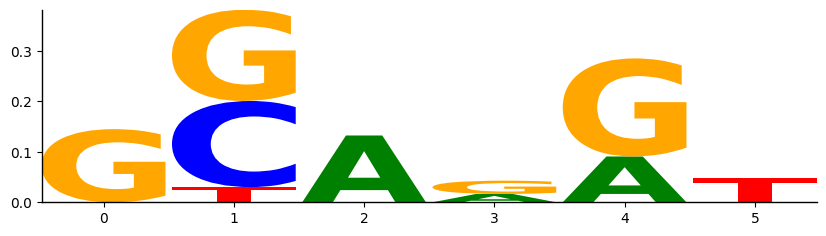

In [29]:
make_logo(kernel)

# Exercise: Iterate over kernels and plot them

`miRNA = 'TATTGCACTTGTCCCGGCCT'`\
`miRNA_rec_compl = 'AGGCCGGGACAAGTGCAATA'`

Can you see some interesting kernels?

In [17]:
# TODO

# SHAP

## Deep Explainer

In [42]:
explainer = shap.DeepExplainer(model, X_train[:100])


/usr/local/lib/python3.10/dist-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [43]:
index = 0

shap_values = explainer.shap_values(X_test[index:index + 1])

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


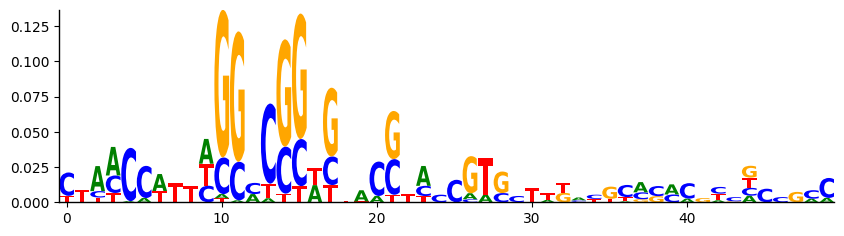

In [44]:
make_logo(shap_values[0, :, :, 0])

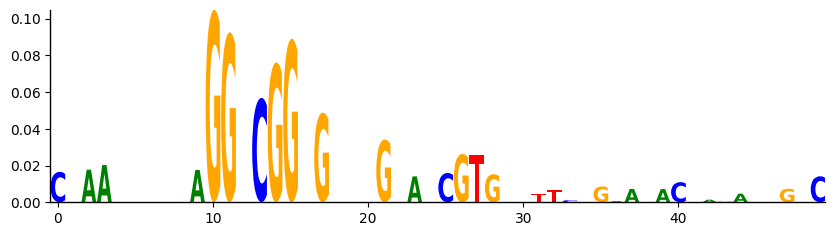

In [45]:
# project the importance at each position onto the base that's actually present
make_logo(shap_values[0, :, :, 0] * X_test[index])

## Exercise: Plot several samples to look for a pattern

Reminder:
`miRNA = 'TATTGCACTTGTCCCGGCCT'` \
`miRNA_rec_compl = 'AGGCCGGGACAAGTGCAATA'`

In [ ]:
# TODO

## Gradient Explainer

In case layers of your neural network are not supported by a Deep Explainer, you can try using Gradient Explainer.

Both of these explainers are specifying on Deep Neural Networks.

In [46]:
explainer = shap.GradientExplainer(model, X_train[:100])

In [47]:
index = 0

shap_values = explainer.shap_values(X_test[index:index + 1])

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(


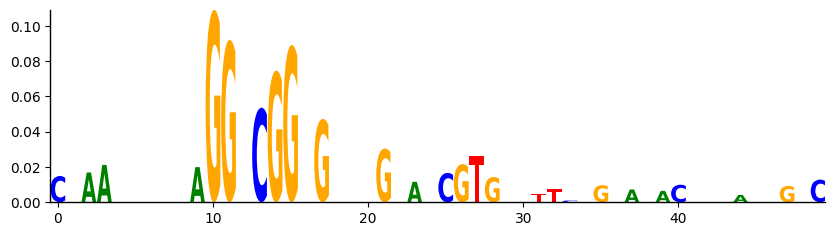

In [48]:
make_logo(shap_values[0, :, :, 0] * X_test[index])

---
End of main section. Examples of some more interpretaion techniques follows. But SHAP package is widely used now.

# Grad-CAM

In [20]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    # heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer_output), axis=-1)
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()


# Exercise: Get name of last convolutional layer from your model

Hint: it is in the output of `model.summary()`

Note: when creating a model architecture, you can name your layers.

In [71]:
def apply_gradcam(test_sample):
  # It is common to name our layers in more complex NNs
  # f.e: model.add(Dense(units = 10, name="dense_1"))
  last_conv_layer_name = "conv1d_44" # <- PUT HERE

  sample = tf.reshape(test_sample, [-1,50,4])
  preds = model.predict(sample)
  print("Predicted:", preds)

  # Generate class activation heatmap
  heatmap = make_gradcam_heatmap(sample, model, last_conv_layer_name)

  print(test_sample.shape)
  print(heatmap.shape)

  return heatmap

In [76]:
def plot_heatmap(heatmap, seq):

  chars = [char for char in seq]
  df_to_vis = pd.DataFrame(heatmap.reshape((50,1)), chars)

  ticks = "auto"
  fig, ax = plt.subplots(figsize=(25, 2.8))
  sb.heatmap(df_to_vis[:50].T, cmap="YlOrBr", annot=False, vmin = 0, vmax = 1, xticklabels=ticks, yticklabels=[], cbar_kws={"orientation": "horizontal"}, ax=ax)
  ax.invert_yaxis()
  plt.tight_layout()
  plt.show()

In [77]:
sample_num = 6
ohe_sample = sequence_to_ohe(df["gene"][sample_num:sample_num + 1], 50)
label = df['label'].iloc[sample_num]
print('Label', label)
heatmap = apply_gradcam(ohe_sample)

Label 1
1/1 [==============================] - 0s 34ms/step
Predicted: [[0.82825494]]
(1, 50, 4)
(50,)


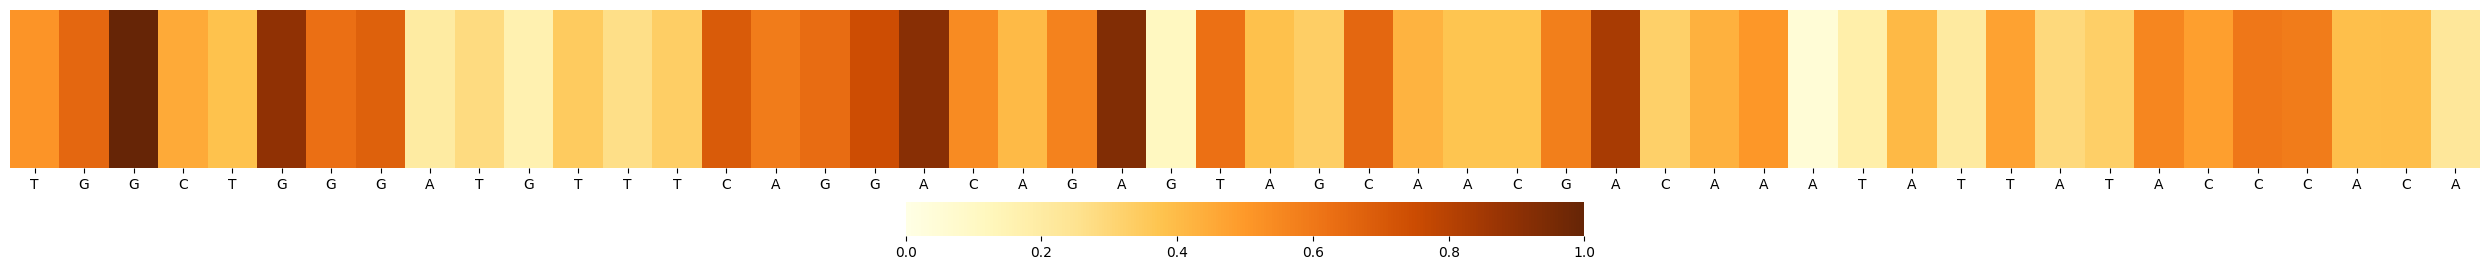

In [78]:
plot_heatmap(heatmap, df["gene"].iloc[sample_num])

# Exercise: Plot several samples to look for a pattern

Reminder:
`miRNA = 'TATTGCACTTGTCCCGGCCT'` \
`miRNA_rec_compl = 'AGGCCGGGACAAGTGCAATA'`

In [ ]:
# TODO

# Exercise: Analyze results

How would you analyze results from interpretation? Asking for a friend.

# Integrated gradients

Your model, is a learned function that describes a mapping between your input feature space, and an output space defined by probability value between 0 and 1. Early interpretability methods for neural networks assigned feature importance scores using gradients, which tell you which pixels have the steepest local relative to your model's prediction at a given point along your model's prediction function. However, gradients only describe local changes in your model's prediction function with respect to pixel values and do not fully describe your entire model prediction function. As your model fully "learns" the relationship between the range of an individual pixel and the correct class, the gradient for this pixel will saturate, meaning become increasingly small and even go to zero. Consider the simple model function below:

In [120]:
def f(x):
  """A simplified model function."""
  return tf.where(x < 0.8, x, 0.8)

def interpolated_path(x):
  """A straight line path."""
  return tf.zeros_like(x)

x = tf.linspace(start=0.0, stop=1.0, num=6)
y = f(x)




- **left**: Your model's gradients for pixel x are positive between 0.0 and 0.8 but go to 0.0 between 0.8 and 1.0. Pixel x clearly has a significant impact on pushing your model toward 80% predicted probability on the true class. Does it make sense that pixel x's importance is small or discontinuous?

- **right**: The intuition behind IG is to accumulate pixel x's local gradients and attribute its importance as a score for how much it adds or subtracts to your model's overall output class probability. You can break down and compute IG in 3 parts:
  - interpolate small steps along a straight line in the feature space between 0 (a baseline or starting point) and 1 (input pixel's value)
  - compute gradients at each step between your model's predictions with respect to each step
  - approximate the integral between your baseline and input by accumulating (cumulative average) these local gradients.


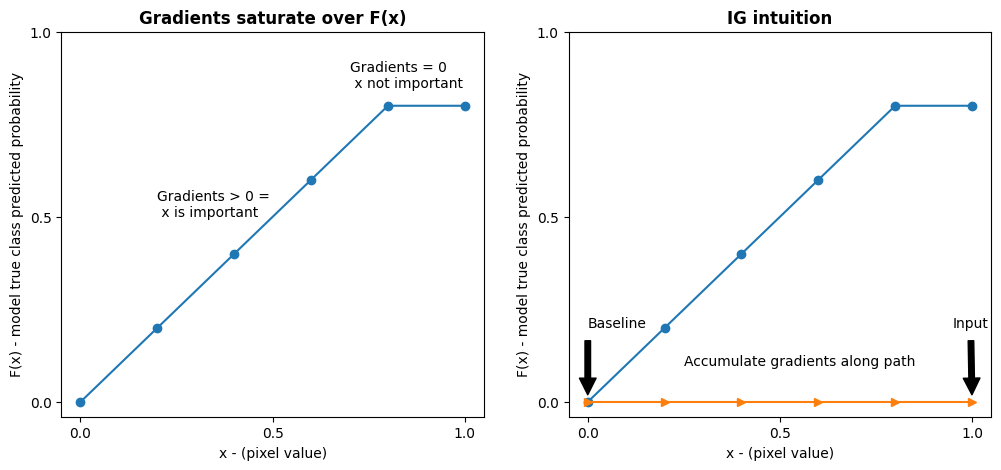

In [121]:
fig = plt.figure(figsize=(12, 5))
ax0 = fig.add_subplot(121)
ax0.plot(x, f(x), marker='o')
ax0.set_title('Gradients saturate over F(x)', fontweight='bold')
ax0.text(0.2, 0.5, 'Gradients > 0 = \n x is important')
ax0.text(0.7, 0.85, 'Gradients = 0 \n x not important')
ax0.set_yticks(tf.range(0, 1.5, 0.5))
ax0.set_xticks(tf.range(0, 1.5, 0.5))
ax0.set_ylabel('F(x) - model true class predicted probability')
ax0.set_xlabel('x - (pixel value)')

ax1 = fig.add_subplot(122)
ax1.plot(x, f(x), marker='o')
ax1.plot(x, interpolated_path(x), marker='>')
ax1.set_title('IG intuition', fontweight='bold')
ax1.text(0.25, 0.1, 'Accumulate gradients along path')
ax1.set_ylabel('F(x) - model true class predicted probability')
ax1.set_xlabel('x - (pixel value)')
ax1.set_yticks(tf.range(0, 1.5, 0.5))
ax1.set_xticks(tf.range(0, 1.5, 0.5))
ax1.annotate('Baseline', xy=(0.0, 0.0), xytext=(0.0, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
ax1.annotate('Input', xy=(1.0, 0.0), xytext=(0.95, 0.2),
             arrowprops=dict(facecolor='black', shrink=0.1))
plt.show();


## Establish a baseline

### Why do we need a baseline?

Baseline selection is a fundamental to the process of attribution. No discussion of cause is complete without a comparison. An example motivating the necessity of a baseline is to characterize situations when the absence of a feature can be informative. When compared against a baseline with the feature present would help identify the feature as important. E.g. in a medical diagnostic model, a diagnosis for H. pylori infection might be ruled out based on the absence of elevated IgA or IgG.


### How to select a baseline?

For images, the simples baseline is a black image. It may also make sense to use a noise image as a baseline and even average the attributions over several different noise baselines.

### Sanity Checking Baseline

When model treats one of the classes as a 'default' class, we want the baseline to have the default class label. For instance, consider a toxicity model for text that outputs a sigmoid score. The model may be looking for indicators of toxicity in the text and predicting non-toxic only when there no toxicity indicators. The model treats the non-toxic class as the default as there is no positive evidence for non-toxicity. In this case a good baseline may be one that has a sigmoid score of 0.0 (meaning non-toxic) as the model may be using the entire range of the sigmoid output (from 0.0 to 1.0) to indicate confidence of toxicity. On the other hand, a text sentiment model may be more symmetric across the positive and negative classes with there being distinct triggers for either class. For such a model a good baseline would be one with a sigmoid score of 0.5 that is balanced between the two classes.

### Binary Classification models may need special treatment

Sometimes you have a classification problem with two classes where membership in either class involves the presence of signal. That is, it is not the case that one of the classes is synonymous with absence of signal (no toxicity, no diabetic retinopathy etc.)

Ideally, a good baseline should give equal probability to both classes. In our experience, this may not be true.

Here, you will use a black image whose pixel values are all zero.

In [122]:
baseline = tf.zeros(shape=(50,4))

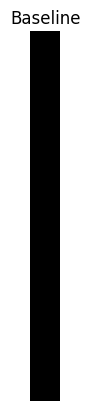

In [125]:
plt.imshow(baseline, cmap='gray')
plt.title("Baseline")
plt.axis('off')
plt.show()

## Interpolate images

First, you will generate a linear interpolation between the baseline and the original image. You can think of interpolated images as small steps in the feature space between your baseline and input.

In [180]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

In [153]:
def interpolate_images(baseline,
                       image,
                       alphas):
  delta = image - baseline
  interploated_inputs = tf.vectorized_map(lambda x: baseline + delta * x, alphas)
  return interploated_inputs

In [181]:
ohe_sample_tf = tf.convert_to_tensor(ohe_sample, dtype=tf.float32)

interpolated_images = interpolate_images(
    baseline=baseline,
    image=ohe_sample_tf[0, :, :],
    alphas=alphas)


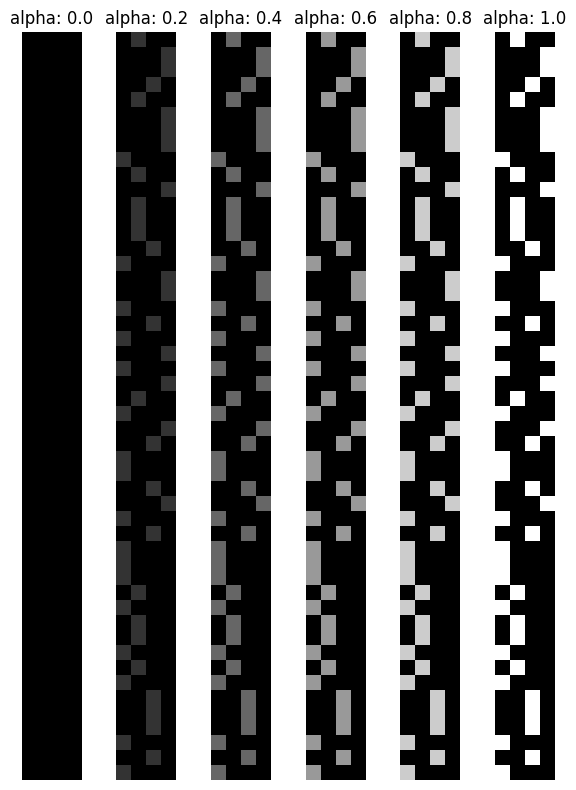

In [182]:
fig = plt.figure(figsize=(6, 8))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image, cmap='gray', vmin=0, vmax=1)
  plt.axis('off')

plt.tight_layout();


In [173]:
def compute_gradients(images, model):
  with tf.GradientTape() as tape:
    tape.watch(images)
    probs = model(images)
  return tape.gradient(probs, images)


In [189]:
path_gradients = compute_gradients(
    images=interpolated_images,
    model=model)


In [190]:
print(path_gradients.shape)


(51, 50, 4)


In [191]:
pred_proba = model(interpolated_images)




- **left**: This plot shows how your model's confidence in the "binding site" class varies across alphas.

- **right**: The right plot shows the average gradients magnitudes over alpha more directly. Your model "learns" the most from gradients at lower values of alpha before saturating.


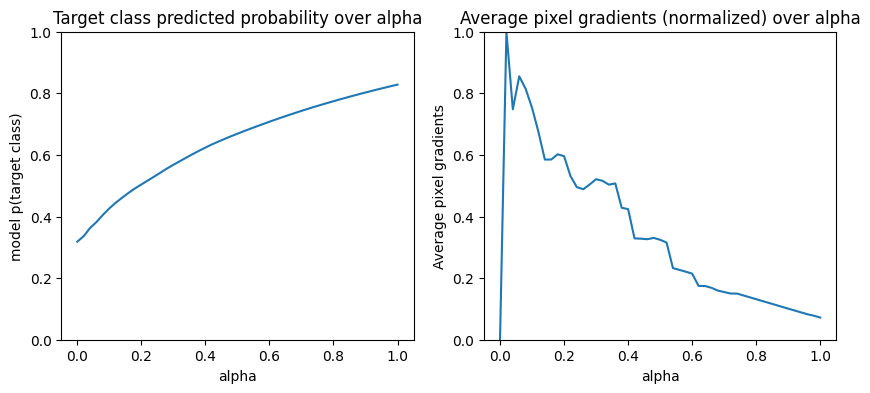

In [193]:
plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2])
# Normalize gradients to 0 to 1 scale. E.g., (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);


## Putting it all together

In [163]:
# implementation based on https://github.com/mhorlacher/igrads

@tf.function
def _interpolate_inputs(inputs, baseline, alphas=None, steps=50):
    if alphas == None:
        alphas = tf.linspace(start=0.0, stop=1.0, num=steps+1)
    delta = inputs - baseline
    interploated_inputs = tf.vectorized_map(lambda x: baseline + delta * x, alphas)
    return interploated_inputs

def _apply_fn(fn, inputs):
    if isinstance(inputs, tf.Tensor) or isinstance(inputs, np.ndarray):
        # if inputs is a tensor or array, apply function directly
        return fn(inputs)
    elif isinstance(inputs, list):
        # if inputs is a list, apply function to each element of inputs
        return [fn(x) for x in inputs]
    elif isinstance(inputs, dict):
        # if inputs is a dict, apply function to each value of inputs (preserve dict)
        return {key: fn(value) for key, value in inputs.items()}
    else:
        raise ValueError('Unsupported type: {}'.format(type(inputs)))

def _mask(x, mask):
    # apply mask to x (both are either tf.Tensor or np.ndarray)
    return tf.math.multiply(x, tf.stop_gradient(mask))

def _apply_mask(x, mask):
    if isinstance(mask, tf.Tensor) or isinstance(mask, np.ndarray):
        # if mask is a tensor, apply it to each element of x
        return _apply_fn(lambda y: _mask(y, mask), x)
    elif isinstance(mask, list):
        # if mask is a list, apply i'th element of mask to i'th element of x
        assert isinstance(x, list)
        assert len(x) == len(mask)
        return [_mask(x[i], mask[i]) for i in range(len(mask))]
    elif isinstance(mask, dict):
        # if mask is a dict, apply mask[key] to x[key]
        assert isinstance(x, dict)
        assert len(x) == len(mask)
        return {key: _mask(x[key], mask[key]) for key in mask}
    else:
        raise ValueError('Unsupported type: {}'.format(type(mask)))

def _compute_gradients(inputs, model, target_mask=None, postproc_fn=None):
    with tf.GradientTape(persistent=True) as tape:
        # watch gradients of inputs
        tape.watch(inputs)

        # run model predictions on inputs
        pred = model(inputs)

        if postproc_fn is not None:
            # optional: apply post-processing function (e.g. softmax on predicted logits)
            pred = _apply_fn(postproc_fn, pred)

        if target_mask is not None:
            # optional: apply mask, e.g. one-hot for classification
            pred = _apply_mask(pred, target_mask)

        # reduce_sum for each batch
        pred_sum = _apply_fn(lambda x: tf.reduce_sum(x, axis=tf.range(1, tf.rank(x))), pred)

    return _apply_fn(lambda x: tape.gradient(x, inputs), pred_sum)

def compute_gradients(model, images):
  with tf.GradientTape() as tape:
    tape.watch(images)
    probs = model(images)
    #probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
    #probs = preds[:, target_class_idx]
  return tape.gradient(probs, images)

#@tf.function
def _integral_approximation(gradients):
    # trapezoidal
    grads = _apply_fn(lambda x: (x[:-1] + x[1:]) / tf.constant(2.0), gradients)
    integrated_gradients = _apply_fn(lambda x: tf.math.reduce_mean(x, axis=0), grads)
    return integrated_gradients

#@tf.function
def integrated_gradients(inputs, model, target_mask=None, postproc_fn=None, baseline=None, alphas=None, steps=50):
  # define zero baseline if no other baseline is specified
  if baseline is None:
    baseline = tf.zeros(tf.shape(inputs))

  # create interpolatioted inputs between inputs and baseline
  interpolated_inputs = _interpolate_inputs(inputs, baseline, alphas, steps)

  # compute gradients for interpolated inputs
  grads = _compute_gradients(interpolated_inputs, model, target_mask, postproc_fn)

  # approximate the gradients integral
  integrated_grads = _integral_approximation(grads)

  # scale integrated gradients with respect to input.
  integrated_grads = _apply_fn(lambda x: (inputs - baseline) * x, integrated_grads)

  return integrated_grads

In [169]:
m_steps = 200

baseline = tf.zeros(shape=(50,4), dtype=tf.float32)
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)
attributions_black = integrated_gradients(tf.convert_to_tensor(ohe_sample[0, :, :], dtype=tf.float32), model, baseline=baseline,).numpy()

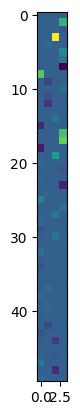

In [170]:
plt.imshow(attributions_black)

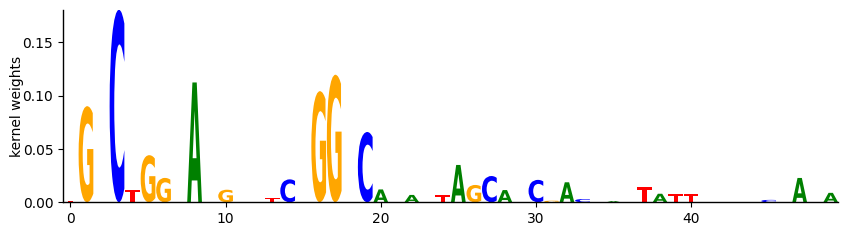

In [172]:
make_logo(attributions_black * tf.convert_to_tensor(ohe_sample[0, :, :], dtype=tf.float32))